In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import deepchem as dc
import matplotlib.pyplot as plt
import matplotlib_venn as mpv
from scipy.stats import pearsonr
import umap

Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [2]:
! pip install rdkit-pypi
! pip install deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install -U --ignore-installed numba
! pip install umap-learn
! pip install molvs
! pip install bravado

  Using cached numba-0.59.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.42.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (4.8 kB)
  Using cached numpy-1.26.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numba-0.59.1-cp39-cp39-macosx_11_0_arm64.whl (2.6 MB)
Using cached llvmlite-0.42.0-cp39-cp39-macosx_11_0_arm64.whl (28.8 MB)
Using cached numpy-1.26.4-cp39-cp39-macosx_11_0_arm64.whl (14.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.8.1 requires numpy<1.25.0,>=1.17.3, but you have numpy 1.26.4 which is incompatible.


In [10]:
# dataset_path = '../../../../'
# moe = pd.read_csv('/Users/jayceepang/msse/capstone/data/datasets/NEK2_1_uM_min_50_pct_binding_with_moe_descriptors.csv') # these were the original feats
# as of June 1 I remade the datasets 
moe = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK2/bind/NEK2_binding_moe_scaled_df.csv')
moe


,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,BCUT_PEOE_2,BCUT_PEOE_3,BCUT_SLOGP_0_per_atom,...,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol_per_atom,zagreb_per_atom,subset,compound_id,base_rdkit_smiles,fold,active
0,6.171916,-2.880666,-0.242820,-0.138540,3.174018,1.664387,2.956607,-2.776526,-1.873703,-6.030218,...,-0.183657,-0.206969,-1.235610,-0.816892,0.194164,train,kdb_2562,Cn1cnc2c(N)ncnc21,fold4,0
1,0.504051,0.725849,-0.489283,1.847024,0.319364,-0.163025,-0.395619,0.682256,0.269110,-0.059029,...,-0.291313,-0.206969,0.257966,-0.011573,-0.539664,train,kdb_3056,CNCc1ccc(-c2cc(-c3nc(-c4ccc(S(=O)(=O)C(C)C)cc4...,fold2,0
2,-1.005664,1.857896,-0.732021,1.562579,-0.222465,-0.258641,0.555600,-0.776457,0.794523,0.996309,...,-0.398969,-0.206969,0.769733,1.066145,0.502085,train,kdb_3510,CNC(=O)Nc1ccc2c(c1)CC[C@@]21OC(=O)N(CC(=O)N(Cc...,fold4,0
3,-0.272463,0.356568,-0.742466,1.119058,0.391476,0.992658,-0.464873,0.315869,0.916609,0.039975,...,-0.398969,-0.206969,-0.450504,0.540647,1.080537,train,kdb_2948,CC(=O)Nc1ccc2ccn(-c3cc(NC4CC4)n4ncc(C#N)c4n3)c2c1,fold3,0
4,1.507075,-0.643926,1.305948,-0.705561,1.121426,1.445349,0.459030,1.731704,-1.692399,-0.232629,...,0.031654,-0.206969,-0.736191,-0.070246,0.125982,train,kdb_2748,Cc1cccc(-c2nc(Nc3ccncc3)c3ccccc3n2)n1,fold4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,-0.829305,-0.606676,-0.711927,-0.580871,-1.457042,-1.209951,1.095581,-0.537771,1.347102,0.065689,...,-0.398969,-0.206969,-0.128627,3.562265,1.194907,test,kdb_1627,CN[C@H]1C[C@@H]2O[C@](C)([C@H]1OC)n1c3ccccc3c3...,fold1,1
1404,1.325649,-1.222164,2.374258,-1.635889,1.987426,1.693552,-0.893856,0.765541,-1.947318,-2.045763,...,-0.398969,-0.206969,-1.147903,-0.762591,0.125982,test,kdb_2758,c1ccc(-c2ccnc3[nH]ccc23)cc1,fold1,1
1405,1.130839,-0.968577,0.678757,-0.691671,0.130626,0.118424,0.656058,-1.451143,-0.473444,0.291278,...,-0.398969,-0.206969,-0.236771,0.214837,-0.364932,test,kdb_2288,COCCOCCOc1cc2ncc3c4ccc(C#N)cc4[nH]c3c2cc1OC,fold1,1
1406,-0.073978,-0.955461,-0.432754,-0.659996,-1.040959,-0.678455,-0.542517,0.329226,0.102786,0.353850,...,-0.291313,-0.206969,0.012301,-0.364379,-0.601298,test,kdb_2768,CNC(=O)c1ccccc1Nc1nc(Nc2ccc(N3CCOCC3)cc2)ncc1Cl,fold1,1


In [11]:
moe_other_cols = moe[['subset','compound_id'	,'base_rdkit_smiles',	'fold',	'active']]
moe.drop(columns=['subset','compound_id'	,'base_rdkit_smiles',	'fold',	'active'],inplace=True)
moe

,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,BCUT_PEOE_2,BCUT_PEOE_3,BCUT_SLOGP_0_per_atom,...,vsurf_Wp2_per_atom,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol_per_atom,zagreb_per_atom
0,6.171916,-2.880666,-0.242820,-0.138540,3.174018,1.664387,2.956607,-2.776526,-1.873703,-6.030218,...,3.468620,-0.868155,-0.143591,-0.065674,-0.058947,-0.183657,-0.206969,-1.235610,-0.816892,0.194164
1,0.504051,0.725849,-0.489283,1.847024,0.319364,-0.163025,-0.395619,0.682256,0.269110,-0.059029,...,0.992820,1.502885,0.973047,0.809867,0.211529,-0.291313,-0.206969,0.257966,-0.011573,-0.539664
2,-1.005664,1.857896,-0.732021,1.562579,-0.222465,-0.258641,0.555600,-0.776457,0.794523,0.996309,...,-1.184218,-0.544634,-0.283901,-0.277498,-0.445342,-0.398969,-0.206969,0.769733,1.066145,0.502085
3,-0.272463,0.356568,-0.742466,1.119058,0.391476,0.992658,-0.464873,0.315869,0.916609,0.039975,...,0.588559,0.358619,-0.266362,-0.291620,-0.445342,-0.398969,-0.206969,-0.450504,0.540647,1.080537
4,1.507075,-0.643926,1.305948,-0.705561,1.121426,1.445349,0.459030,1.731704,-1.692399,-0.232629,...,1.382426,0.065496,-0.026665,-0.023309,0.018332,0.031654,-0.206969,-0.736191,-0.070246,0.125982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,-0.829305,-0.606676,-0.711927,-0.580871,-1.457042,-1.209951,1.095581,-0.537771,1.347102,0.065689,...,-0.766612,0.158861,0.066875,0.132029,-0.058947,-0.398969,-0.206969,-0.128627,3.562265,1.194907
1404,1.325649,-1.222164,2.374258,-1.635889,1.987426,1.693552,-0.893856,0.765541,-1.947318,-2.045763,...,1.357519,-1.393605,-0.798373,-0.785877,-0.754457,-0.398969,-0.206969,-1.147903,-0.762591,0.125982
1405,1.130839,-0.968577,0.678757,-0.691671,0.130626,0.118424,0.656058,-1.451143,-0.473444,0.291278,...,-0.391756,-0.477324,-0.745756,-0.715268,-0.483981,-0.398969,-0.206969,-0.236771,0.214837,-0.364932
1406,-0.073978,-0.955461,-0.432754,-0.659996,-1.040959,-0.678455,-0.542517,0.329226,0.102786,0.353850,...,-0.275996,0.656085,0.844429,0.739259,0.520645,-0.291313,-0.206969,0.012301,-0.364379,-0.601298


In [12]:
# numeric_cols =moe.select_dtypes(include=['number']).columns
# tolist =numeric_cols.to_list()
# numeric_cols = tolist[1:]


In [13]:
numeric_cols = moe.columns.to_list()
for col in numeric_cols:
  moe[col]=moe[col].astype(float)

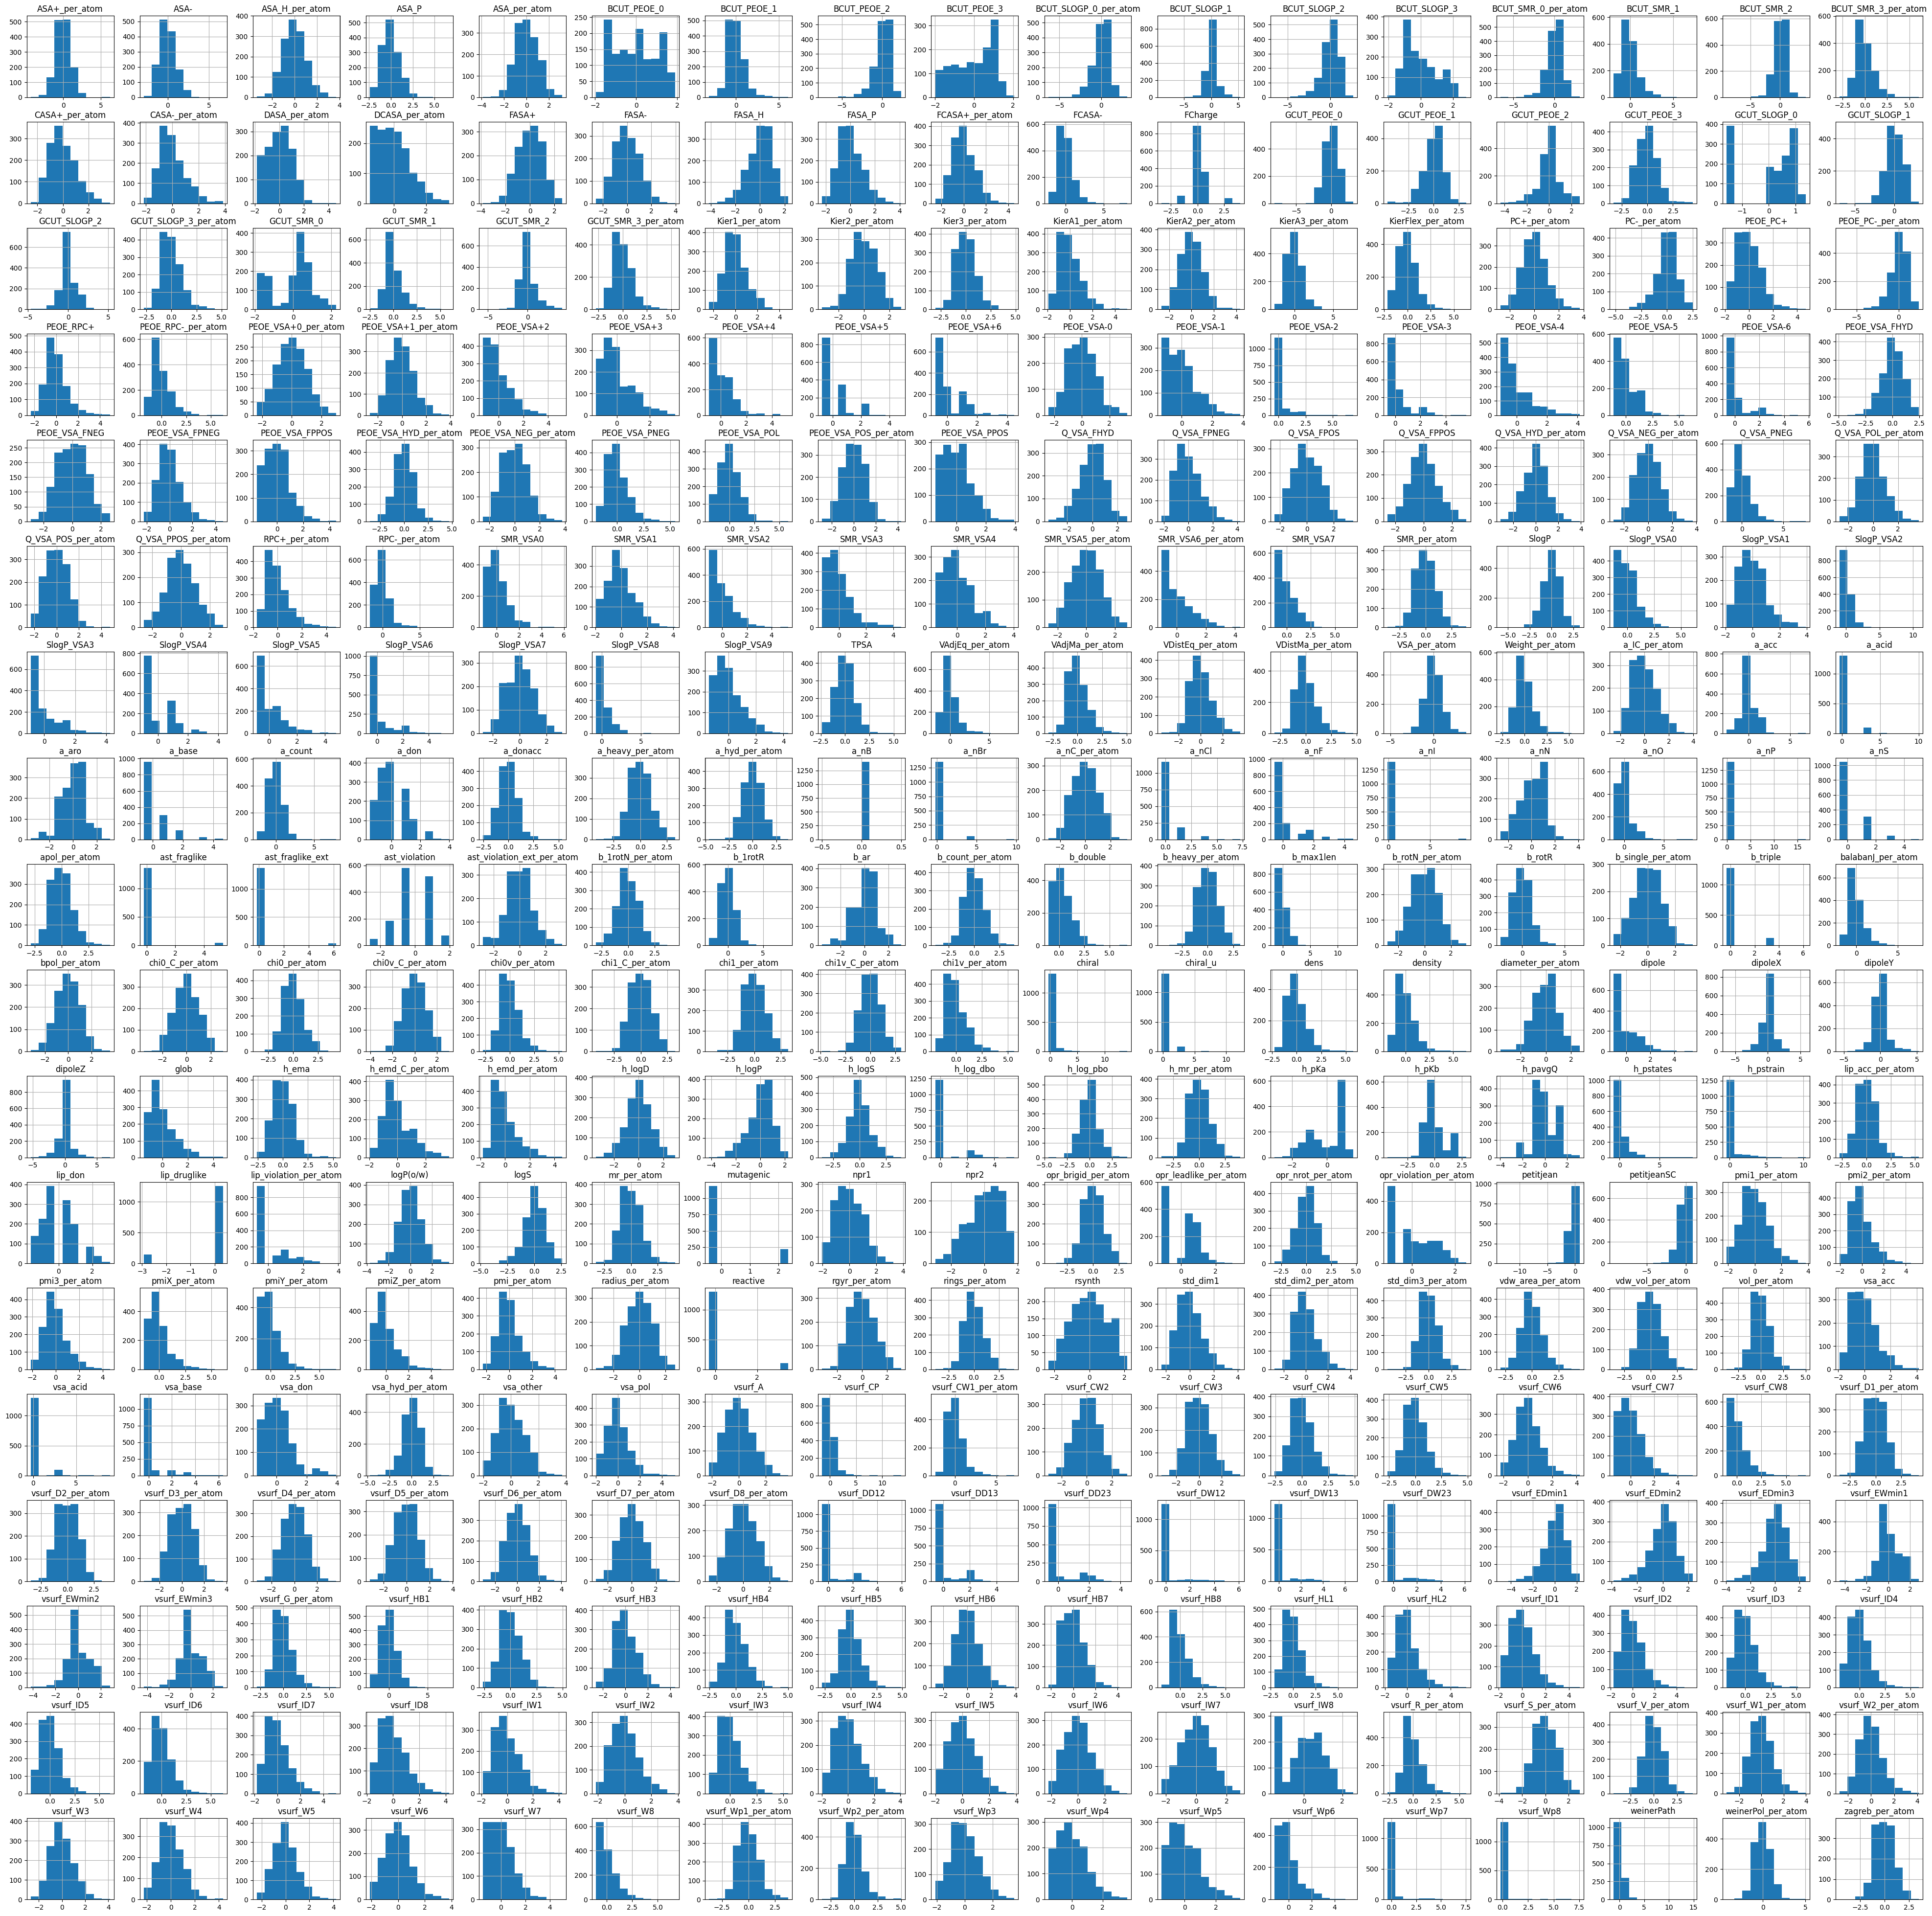

In [14]:
moe[numeric_cols].hist(figsize=(50,50));

In [15]:
moe_numeric = moe[numeric_cols]
moe_numeric.shape # (1408, 306)

(1408, 306)

In [ ]:
# reducer = umap.UMAP(n_components=2)
# embedding = reducer.fit_transform(df)
feat_colors = df[:, 0]  
num_features = len(moe_numeric)
# num_rows = int(num_features**0.5) 
# num_cols = (num_features+num_rows-1) //num_rows
num_rows=19
num_cols=19
fig, axes = plt.subplots(num_rows, num_cols, figsize=(50, 50))
# for i in range(num_features): 
    # plt.scatter(embedding[:, 0], embedding[:, 1], c=feat_colors, cmap='viridis', s=10)
    # plt.colorbar(label=f'Feature {i}')
    # plt.title('UMAP Proj')
    # plt.xlabel('Dim 1')
    # plt.ylabel('Dim 2')
    # plt.show();
for i, feat in enumerate(df):
    if i >= num_rows * num_cols:
        break
    row = i//num_cols
    col = i%num_cols
    ax = axes[row,col]
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(feat.reshape(-1, 1)) 
    # embedding = reducer.fit_transform(df)
    ax.scatter(embedding[:, 0], embedding[:, 1], c='b', s=10) 
    ax.set_title(f'UMAP Visualization of {feat}')
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')

plt.tight_layout()
plt.show();